# Ideas and thoughts

I refer to "galactic years" as just years using their ordinal value (i.e. 1st, 2nd, … 26th), since there is a clear constant increment in the raw data.

## Part 1 of the task
enrich data using open source info? - later, after getting some interim results from basic algorithms  
Match countries with galaxies using that information? - same  
Add Human development index feature using UN methodology - after basic algos  
Distribution of index over years for each country - visualize  

### Step 0. Preprocessing choices
#### Categorical data encoding
We have 2 categorical features "galactic year" and "galaxy" of cardinalities 26 and 181 respectively  
**Options for year encoding:**  
1) Some approach from time-series analysis. Could be just ordinal encoding (1, 2, 3 ... 26)  

There is a weird peak of average y in the last 4 years 

**Options for "galaxy" encoding:**  
1) One-hot encoding — costly in terms of additional features  
2) Mean encoding — reflects relationship between galaxy and it's average index, but prone to overfitting (careful)
#### Dealing with missing values
Options:  
1) Blanket replace NaN with zeroes - simplest  
2) Blanket replace NaN with feature mean - also simple  
3) Copy value from closest neighbour in feature space - involve metrics  
4) Using some EM algorithm - advanced
5) Delete features with more than some amount of missing values  


### Data exploration insights
Is there any cyclicity of average y of all galaxies between galactic years? — No, at least for cycles with periods of less than 26 years. Based on a ```data.groupby(['galactic year'])['y'].mean()``` graph.  
Also on the same graph there exists an anomalous peak around last 4 years. — something to look into

## Part 2 of the task
Every galaxy has a limited potential for improvement in the index described by potential:  
$$P_i = -\ln (y_i + 0.01) + 3,$$
where $y_i$ is the development index of a galaxy $i$.  
Likely index increase $\Delta y_i$ dependent on potential for improvement $P$ and on extra energy availability $E_i$ is described by the following function:

$$\Delta y_i = \dfrac {E_i P_i^2}{1000} = \dfrac{E_i(-\ln (y_i + 0.01) + 3)^2}{1000}$$

The task is to maximize $\displaystyle \sum_{i = 0}^{889} \Delta y_i (E_i)$ given the constraints: 
* $E = \displaystyle \sum_{i=0}^{889}E_i = 50000$ units available for allocation (across 890 objects --)
* $0 \leq E_i \leq 100 $ for all $i$
* all galaxies with $y_i < 0.7$ should be allocated at least 10% of the total energy available (i.e. 5000 units)

### Type = Linear programming problem with constraints?

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

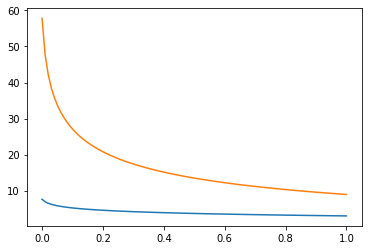

In [8]:
xs = np.linspace(0, 1, 100)
ys = (-np.log(xs + 0.01) + 3)
plt.plot(xs, ys, label='a')
plt.plot(xs, ys**2, label='b')